
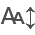

8564

In [4]:
import duckdb
import pandas as pd
import numpy as np
from itables import init_notebook_mode, show

# 0) init
init_notebook_mode(all_interactive=True)
con = duckdb.connect()

# 1) query all “destruction” captions
q = """
SELECT
  *
FROM read_parquet('../data/blip_captioned_images.parquet')
WHERE lower(caption) LIKE '%rubble%'
   OR lower(caption) LIKE '%destr%'
   OR lower(caption) LIKE '%ruin%'
   OR lower(caption) LIKE '%devast%'
   OR lower(caption) LIKE '%demolish%'
   OR lower(caption) LIKE '%crater%'
   OR lower(caption) LIKE '%bomb%'   
"""
df_hits = con.execute(q).df()

# 2) fill any nulls so string ops won’t break
# df_hits['caption'] = df_hits['caption'].fillna('')

len(df_hits)

In [5]:
from transformers import pipeline

# 1) Load the QA pipeline
qa = pipeline(
    "question-answering",
    model="distilbert-base-cased-distilled-squad",
    tokenizer="distilbert-base-cased-distilled-squad"
)

# 2) Pick one of your captions as the “context”
context = "People inspect the remains of a destroyed building following Israeli bombardment in Khan Yunis in the southern Gaza Strip on October 18, 2023."

# 3) Ask your questions
questions = [
    "Who caused the destruction?",
    "What was destroyed?",
    "Where did the destruction occur?"
]

for question in questions:
    result = qa(question=question, context=context)
    print(f"Q: {question}")
    print(f"A: {result['answer']}  (score: {result['score']:.2f})\n")


/mnt/raid1/MSCs/AY2425/skaul/miniconda3/envs/bias-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0


Q: Who caused the destruction?
A: Israeli  (score: 0.78)

Q: What was destroyed?
A: building  (score: 0.48)

Q: Where did the destruction occur?
A: Khan Yunis in the southern Gaza Strip  (score: 0.43)



In [ ]:
import pandas as pd
from transformers import pipeline

# 1) Load & filter
df = pd.read_parquet(
    "../data/blip_captioned_images.parquet",
    columns=["image_id","article_id","source_domain","caption"]
).fillna("")
mask = df.caption.str.contains(r"rubble|destr|ruin|devast|demolish|crater",
                               case=False, na=False)
df = df[mask].reset_index(drop=True)

# 2) QA pipeline on GPU
qa = pipeline(
    "question-answering",
    model="distilbert-base-cased-distilled-squad",
    tokenizer="distilbert-base-cased-distilled-squad",
    device=0,
)

questions = {
    "agent":    "Who caused the destruction?",
    "location": "Where did the destruction occur?"
}

meta_inputs = []
qa_inputs   = []

for _, row in df.iterrows():
    for qkey, qtext in questions.items():
        meta_inputs.append({
            "image_id":      row.image_id,
            "article_id":    row.article_id,
            "source_domain": row.source_domain,
            "caption":       row.caption,
            "question_key":  qkey
        })
        qa_inputs.append({
            "question": qtext,
            "context":  row.caption
        })

# 3) Run QA in batches
qa_results = qa(qa_inputs, batch_size=32)

# 4) Combine metadata + QA outputs
records = []
for meta, out in zip(meta_inputs, qa_results):
    rec = {
        "image_id":      meta["image_id"],
        "article_id":    meta["article_id"],
        "source_domain": meta["source_domain"],
        "caption":       meta["caption"],
        meta["question_key"]: out["answer"]
    }
    records.append(rec)

# 5) Pivot wide, including caption
df_long = pd.DataFrame(records)
df_wide = (
    df_long
    .groupby(
        ["image_id","article_id","source_domain","caption"], 
        as_index=False
    )
    .agg({"agent":"first","location":"first"})
)

df_wide.head()


Device set to use cuda:0
/mnt/raid1/MSCs/AY2425/skaul/miniconda3/envs/bias-analysis/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:395: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [7]:
# your df_wide is assumed to exist with columns: agent, location

# 1) Define keyword sets
location_israel = ['israel','tel aviv']
location_gaza   = ['gaza','rafah','khan yunis','west bank','palestin','jabalia','khan younis','jabaliya']
agent_israel    = ['israel','idf']
agent_gaza      = ['palestin','gaza','hamas']

# 2) Helper to assign a label from keyword list
def label_from_list(value, keywords, label):
    val = value.lower() if isinstance(value, str) else ''
    return label if any(k in val for k in keywords) else None

# 3) Compute `agent_label`
df_wide['agent_label'] = df_wide['agent'].apply(
    lambda x: 
        label_from_list(x, agent_israel, 'Israel')
        or label_from_list(x, agent_gaza, 'Palestine')
        or 'Other'
)

# 4) Compute `location_label`
df_wide['location_label'] = df_wide['location'].apply(
    lambda x: 
        label_from_list(x, location_israel, 'Israel')
        or label_from_list(x, location_gaza, 'Palestine')
        or 'Other'
)

# 5) Inspect
df_wide.head()


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [11]:
# Count where both location_label and agent_label are 'Other'
both_other_count = df_wide[
    (df_wide['location_label'] == 'Other') & 
    (df_wide['agent_label'] == 'Other')
].shape[0]

print(f"Count where both location_label and agent_label are 'Other': {both_other_count}")

# For more detail, show the crosstab between agent_label and location_label
crosstab = pd.crosstab(df_wide['agent_label'], df_wide['location_label'], margins=True)
print(f"\nCrosstab of agent_label vs location_label:")
print(crosstab)

Count where both location_label and agent_label are 'Other': 833

Crosstab of agent_label vs location_label:
location_label  Israel  Other  Palestine   All
agent_label                                   
Israel             133    798       2303  3234
Other               87    833        690  1610
Palestine          128    331        670  1129
All                348   1962       3663  5973


In [106]:
# Filter rows where both agent_label and location_label are either 'Israel' or 'Palestine'
# but also add a condition to exclude rows where they are different
consistent_mask = (
    ((df_wide['agent_label'] == 'Israel') & (df_wide['location_label'] == 'Israel')) |
    ((df_wide['agent_label'] == 'Palestine') & (df_wide['location_label'] == 'Palestine'))
)

consistent_rows = df_wide[consistent_mask]

print(f"Rows where agent_label and location_label are consistently 'Israel' or 'Palestine': {len(consistent_rows)}")

# Show breakdown by combination
print("\nBreakdown:")
print(f"Israel agent + Israel location: {((df_wide['agent_label'] == 'Israel') & (df_wide['location_label'] == 'Israel')).sum()}")
print(f"Palestine agent + Palestine location: {((df_wide['agent_label'] == 'Palestine') & (df_wide['location_label'] == 'Palestine')).sum()}")

consistent_rows

Rows where agent_label and location_label are consistently 'Israel' or 'Palestine': 803

Breakdown:
Israel agent + Israel location: 133
Palestine agent + Palestine location: 670


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [107]:
# Filter to show rows where both agent_label and location_label are 'Other'
both_other_rows = df_wide[
    (df_wide['agent_label'] == 'Other') & 
    (df_wide['location_label'] == 'Other')
]

print(f"Rows where both agent_label and location_label are 'Other': {len(both_other_rows)}")
print("\nSample of these rows:")
both_other_rows.head(10)

Rows where both agent_label and location_label are 'Other': 833

Sample of these rows:


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [108]:
# Create a new dataframe filtering out cases where both labels are 'Other'
destroyed_df = df_wide[~((df_wide['agent_label'] == 'Other') & (df_wide['location_label'] == 'Other'))].copy()

print(f"Original df_wide shape: {df_wide.shape}")
print(f"Filtered destroyed_df shape: {destroyed_df.shape}")
print(f"Removed {df_wide.shape[0] - destroyed_df.shape[0]} rows where both labels were 'Other'")

# Show the distribution of labels in the new dataframe
print(f"\nCrosstab of agent_label vs location_label in destroyed_df:")
crosstab_destroyed = pd.crosstab(destroyed_df['agent_label'], destroyed_df['location_label'], margins=True)
print(crosstab_destroyed)

destroyed_df.head()

Original df_wide shape: (5973, 8)
Filtered destroyed_df shape: (5140, 8)
Removed 833 rows where both labels were 'Other'

Crosstab of agent_label vs location_label in destroyed_df:
location_label  Israel  Other  Palestine   All
agent_label                                   
Israel             133    798       2303  3234
Other               87      0        690   777
Palestine          128    331        670  1129
All                348   1129       3663  5140


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [111]:
# Create destruction_location_label using the specified logic
def assign_destruction_location_label(row):
    location_label = row['location_label']
    agent_label = row['agent_label']
    
    # First check location directly
    if location_label == 'Israel':
        return 'Israel'
    elif location_label == 'Palestine':
        return 'Palestine'
    
    # If location is 'Other', check agent
    elif location_label == 'Other':
        if agent_label == 'Israel':
            return 'Palestine'
        elif agent_label == 'Palestine':
            return 'Israel'
        else:
            return 'Other'
    
    # Default case
    return 'Other'

destroyed_df['destruction_location_label'] = destroyed_df.apply(assign_destruction_location_label, axis=1)

# Show the distribution
print("Distribution of destruction_location_label:")
print(destroyed_df['destruction_location_label'].value_counts())
print(f"\nCrosstab of destruction_location_label vs location_label:")
print(pd.crosstab(destroyed_df['destruction_location_label'], destroyed_df['location_label'], margins=True))

Distribution of destruction_location_label:
destruction_location_label
Palestine    4461
Israel        679
Name: count, dtype: int64

Crosstab of destruction_location_label vs location_label:
location_label              Israel  Other  Palestine   All
destruction_location_label                                
Israel                         348    331          0   679
Palestine                        0    798       3663  4461
All                            348   1129       3663  5140


Percentage breakdown by source domain (Daily Mail excluded):
destruction_location_label  Israel  Palestine
source_domain                                
abcnews.go.com                10.3       89.7
apnews.com                     8.5       91.5
bbc.com                       11.8       88.2
cnbc.com                       4.3       95.7
cnn.com                        8.1       91.9
express.co.uk                 17.3       82.7
foxnews.com                   20.0       80.0
hindustantimes.com            15.7       84.3
independent.co.uk             16.4       83.6
india.com                     33.3       66.7
indianexpress.com              9.6       90.4
news18.com                    15.5       84.5
newsweek.com                   9.4       90.6
nypost.com                    17.2       82.8
theguardian.com                5.6       94.4
thesun.co.uk                  18.2       81.8
usatoday.com                   2.6       97.4


<Figure size 1200x800 with 0 Axes>

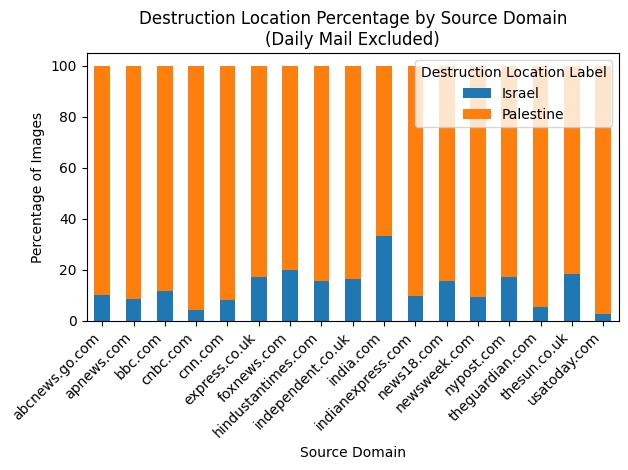

In [121]:
# Calculate percentages for each source domain
viz_data_filtered_grouped = viz_data_filtered.groupby(['source_domain', 'destruction_location_label']).size().reset_index(name='count')
viz_data_filtered_totals = viz_data_filtered.groupby('source_domain').size().reset_index(name='total')

# Merge to get percentages
viz_data_percentages = viz_data_filtered_grouped.merge(viz_data_filtered_totals, on='source_domain')
viz_data_percentages['percentage'] = (viz_data_percentages['count'] / viz_data_percentages['total']) * 100

# Pivot to get Israel and Palestine columns
percentage_pivot = viz_data_percentages.pivot(index='source_domain', columns='destruction_location_label', values='percentage').fillna(0)

print("Percentage breakdown by source domain (Daily Mail excluded):")
print(percentage_pivot.round(1))

# Create stacked bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = percentage_pivot.plot(kind='bar', stacked=True)
plt.title('Destruction Location Percentage by Source Domain\n(Daily Mail Excluded)')
plt.xlabel('Source Domain')
plt.ylabel('Percentage of Images')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Destruction Location Label')
plt.tight_layout()
plt.show()


Original viz_data_filtered shape: (3383, 9)
After dropping duplicates on article_id: (2769, 9)
Removed 614 duplicate articles

Percentage breakdown by source domain (unique articles only):
destruction_location_label  Israel  Palestine
source_domain                                
abcnews.go.com                 9.0       91.0
apnews.com                     7.9       92.1
bbc.com                       11.9       88.1
cnbc.com                       4.3       95.7
cnn.com                        6.9       93.1
express.co.uk                 17.1       82.9
foxnews.com                   20.5       79.5
hindustantimes.com            15.7       84.3
independent.co.uk             17.3       82.7
india.com                     33.3       66.7
indianexpress.com              9.6       90.4
news18.com                    15.5       84.5
newsweek.com                   9.1       90.9
nypost.com                    16.5       83.5
theguardian.com                6.0       94.0
thesun.co.uk                 

<Figure size 1200x800 with 0 Axes>

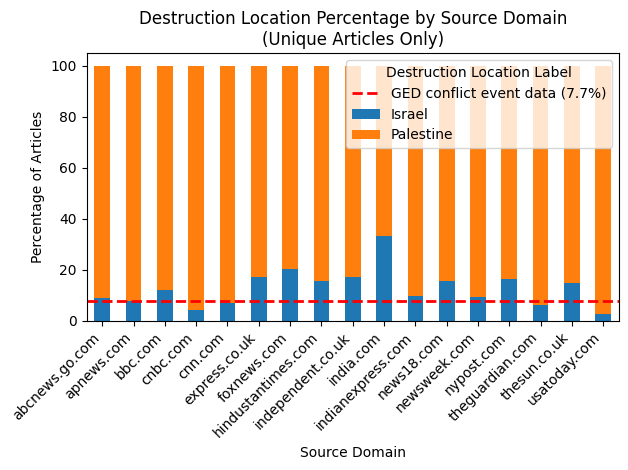

In [150]:
# Create a new dataframe dropping duplicates on article_id
viz_data_filtered_unique = viz_data_filtered.drop_duplicates(subset=['article_id'])

print(f"Original viz_data_filtered shape: {viz_data_filtered.shape}")
print(f"After dropping duplicates on article_id: {viz_data_filtered_unique.shape}")
print(f"Removed {viz_data_filtered.shape[0] - viz_data_filtered_unique.shape[0]} duplicate articles")

# Calculate percentages for each source domain using unique articles
viz_data_unique_grouped = viz_data_filtered_unique.groupby(['source_domain', 'destruction_location_label']).size().reset_index(name='count')
viz_data_unique_totals = viz_data_filtered_unique.groupby('source_domain').size().reset_index(name='total')

# Merge to get percentages
viz_data_unique_percentages = viz_data_unique_grouped.merge(viz_data_unique_totals, on='source_domain')
viz_data_unique_percentages['percentage'] = (viz_data_unique_percentages['count'] / viz_data_unique_percentages['total']) * 100

# Pivot to get Israel and Palestine columns
percentage_pivot_unique = viz_data_unique_percentages.pivot(index='source_domain', columns='destruction_location_label', values='percentage').fillna(0)

print("\nPercentage breakdown by source domain (unique articles only):")
print(percentage_pivot_unique.round(1))

# Create stacked bar chart
plt.figure(figsize=(12, 8))
ax = percentage_pivot_unique.plot(kind='bar', stacked=True)
plt.title('Destruction Location Percentage by Source Domain\n(Unique Articles Only)')
plt.xlabel('Source Domain')
plt.ylabel('Percentage of Articles')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Destruction Location Label')

# Add vertical line at 7.7% for GED conflict event data
plt.axhline(y=7.7, color='red', linestyle='--', linewidth=2, label='GED conflict event data (7.7%)')
plt.legend(title='Destruction Location Label')

plt.tight_layout()
plt.show()


In [129]:
ged = pd.read_csv("../data/GEDEvent_v25_1.csv", low_memory=False)


In [131]:
ged['date_start']

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [148]:

# import pandas as pd
# import matplotlib.pyplot as plt

# # 1) Load GED events
# # ged = pd.read_csv("../data/GEDEvent_v25_1.csv", low_memory=False)

# # 2) Parse & filter dates
# ged = ged[(ged['year'] >= 2023) & (ged['year'] <= 2025)]

# # Filter for Israel
# ged = ged[ged['country'] == 'Israel']
# ged = ged[ged['conflict_name'] == 'Israel: Palestine']
# israel_areas = [
#     "Tel Aviv",
#     "Sderot",
#     "Ashkelon",
#     "Kibbutz Reim Festival Site",
#     "Kibbutz Beeri",
#     "Kissufim Kibbutz",
#     "Holit Settlement",
#     "Netiv HaAsara Settlement",
#     "Karm Abu Salem Border Crossing",
#     "Gush Etzion Settlement",
#     "Ofakim",
#     "Kefar Aza",
#     "Ma'on",
#     "Rehovot",
#     "Shokeda",
#     "Kiryat Shmona",
#     "Zikim Kibbutz",
#     "Jaffa",
#     "Northern Israel",
#     "Northern District",
#     "Southern District",
#     "Kerem Shalom Army Post",
#     "Israel/Egypt Border in Gaza"
# ]

# # Filter for relevant locations - Israel areas
# israel_ged = ged[ged['where_description'].str.contains('|'.join(israel_areas), case=False, na=False)]

# print(f"GED events in Israel areas: {len(israel_ged)}")
# print(f"Unique locations: {israel_ged['where_description'].unique()[:10]}")  # Show first 10

# # Create conflict_location column
# def assign_conflict_location(location):
#     if pd.isna(location):
#         return 'Palestine'
#     location_lower = str(location).lower()
#     for area in israel_areas:
#         if area.lower() in location_lower:
#             return 'Israel'
#     return 'Palestine'

# ged['conflict_location'] = ged['where_description'].apply(assign_conflict_location)

# print(f"\nConflict location distribution:")
# print(ged['conflict_location'].value_counts())

# # Create percentage breakdown for conflict events by location
# ged_grouped = ged.groupby('conflict_location').size().reset_index(name='count')
# ged_total = len(ged)
# ged_grouped['percentage'] = (ged_grouped['count'] / ged_total) * 100

# print("GED Events - Conflict Location Percentage:")
# print(ged_grouped)

# # Create bar chart
# plt.figure(figsize=(10, 6))
# bars = plt.bar(ged_grouped['conflict_location'], ged_grouped['percentage'], 
#                color=['#1f77b4', '#ff7f0e'])
# plt.title('GED Conflict Events by Location (2023-2025)\nIsrael vs Palestine')
# plt.xlabel('Conflict Location')
# plt.ylabel('Percentage of Events (%)')
# plt.ylim(0, 100)

# # Add percentage labels on bars
# for bar, pct in zip(bars, ged_grouped['percentage']):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
#              f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# plt.tight_layout()
# plt.show()



Event counts by location:
conflict_location
Palestine    3872
Israel        322
Name: count, dtype: int64

Percentages:
conflict_location
Palestine    92.3%
Israel        7.7%
Name: count, dtype: object


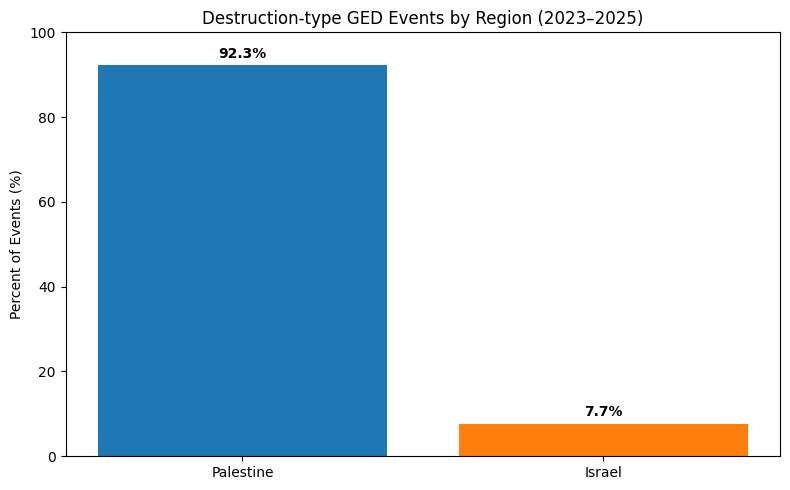

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load & date‐filter your GED export
ged = pd.read_csv("../data/GEDEvent_v25_1.csv", low_memory=False)
ged = ged[(ged['year'] >= 2023) & (ged['year'] <= 2025)]

# 2) Broaden your event‐type filter (optional but recommended)
DESTRUCT_TYPES = [
    "Remote violence",
    "Violence against civilians",
    "Battles",
    "One-sided violence"
]
# ged = ged[ged['country'] == 'Israel']
ged = ged[ged['conflict_name'] == 'Israel: Palestine']

# 3) Define bounding boxes (approximate)  
#    – Gaza Strip: lat 31.1–31.6, lon 34.2–34.6  
#    – Israel proper: lat 29.0–33.3, lon 34.2–35.9  
def assign_conflict_location_by_coords(lat, lon):
    # Gaza Strip box
    if 31.1 <= lat <= 31.6 and 34.2 <= lon <= 34.6:
        return "Palestine"
    # Israel box
    if 29.0 <= lat <= 33.3 and 34.2 <= lon <= 35.9:
        return "Israel"
    return None  # outside study area

# 4) Apply it
ged["conflict_location"] = ged.apply(
    lambda row: assign_conflict_location_by_coords(row.latitude, row.longitude),
    axis=1
)
ged = ged[ged["conflict_location"].notna()]

# 5) Compute distribution
counts = ged["conflict_location"].value_counts()
total  = counts.sum()
pct    = (counts / total * 100).round(1)

print("Event counts by location:")
print(counts)
print("\nPercentages:")
print(pct.astype(str) + "%")

# 6) Plot
plt.figure(figsize=(8,5))
bars = plt.bar(
    pct.index, pct.values,
    color=["#1f77b4", "#ff7f0e"]
)
plt.title("Destruction‐type GED Events by Region (2023–2025)")
plt.ylabel("Percent of Events (%)")
plt.ylim(0, 100)
for bar, val in zip(bars, pct.values):
    plt.text(
        bar.get_x() + bar.get_width()/2, val + 1,
        f"{val:.1f}%", ha="center", va="bottom", fontweight="bold"
    )
plt.tight_layout()
plt.show()


In [159]:
destroyed_df

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [160]:
import pandas as pd
from scipy.stats import chisquare

# 0) Your DataFrame
df = destroyed_df.copy()   # or df_wide, etc.

# 1) GED baseline proportions
p_israel    = 0.077
p_palestine = 0.923

def chi_for(src):
    sub = df[df['source_domain'] == src]
    # Restrict to just the two labels
    sub = sub[sub['destruction_location_label'].isin(['Israel','Gaza'])]
    obs_isr = (sub['destruction_location_label']=="Israel").sum()
    obs_pal = (sub['destruction_location_label']=="Gaza").sum()
    N       = obs_isr + obs_pal
    if N == 0:
        return pd.Series({
            'N':0, 'obs_israel':0, 'obs_gaza':0,
            'exp_israel':0, 'exp_gaza':0,
            'chi2':None, 'p_value':None
        })
    # Now expected sums to N exactly
    exp_isr = p_israel * N
    exp_pal = p_palestine * N
    chi2, p = chisquare(
        f_obs=[obs_isr, obs_pal],
        f_exp=[exp_isr, exp_pal]
    )
    return pd.Series({
        'N':N,
        'obs_israel':obs_isr,
        'obs_gaza':obs_pal,
        'exp_israel':exp_isr,
        'exp_gaza':exp_pal,
        'chi2':chi2,
        'p_value':p
    })

# 2) Run per source_domain
sources = df['source_domain'].unique()
results = pd.DataFrame([chi_for(src) for src in sources], index=sources)
results.index.name = 'source_domain'
results = results.reset_index()

display(results)


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [1]:
# Get 100 random rows from destroyed_df
sample_df = destroyed_df.sample(n=100, random_state=42)
sample_df

NameError: name 'destroyed_df' is not defined